In [26]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from nltk.corpus import stopwords
import numpy as np
import warnings


warnings.filterwarnings('ignore')

nltk.download('stopwords')
imdb_data = pd.read_csv('dataset.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/r_usttt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### шаг 1. подготовка данных для обучения

In [27]:
# разделяем записи на x и y
x_data, y_data = imdb_data['review'][:10000], imdb_data['sentiment'][:10000]

# заменить метки на их численные представления:
# positive => 1
# negative => 0
y_train = y_data.apply(lambda x: 1 if x.startswith('positive') else 0)

# cписок слов, которые необходимо убрать из текста т.к. они не влияют на классификацию
english_stopwords = stopwords.words('english')

x_data_prepped = [] 

# предобрабатывам обучающую выборку
for elem in x_data:
    elem = re.sub(r'\d+', '', elem)  # с помощью регулярки убрать все цифры из строки, т.к. они тоже не влияют на классификацию
    elem = re.sub(r'<br />', '', elem)  # убрать html тег br
    elem = re.sub(r'[^\w\s]', '', elem) # убрать все знаки препинания

    tokens = word_tokenize(elem.lower())  # разделяем текст на отдельные слова и приводим к нижнему регистру
    filtered_tokens = [e for e in tokens if e not in english_stopwords]  # убираем слова принадлежащие english_stopwords
    x_data_prepped.append(' '.join(filtered_tokens))

x_data = x_data_prepped
print(x_data[0]) # проверям, что все предобработалось корректно

# разделяем выборку на обучающую (95%) и тестовую (5%)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_train, test_size=0.05)

one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle cla

В качестве исследуемых способов представления текстов необходимо рассмотреть:

#### 1.Компоненты вектора: частоты ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [28]:
# векторизуем текст, основываясь на частотности слов и ограничиваем количество параметров (max_features), чтобы обучение проходило быстрее
count_vectorizer = CountVectorizer(max_features=250)
x_count_vect = count_vectorizer.fit_transform(x_train)

#### 2. Компоненты вектора: оценки tf-idf для слова ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=250)
x_tfidf_vect = tfidf_vectorizer.fit_transform(x_train)

#### 3. Компоненты вектора: частоты N-грам.

In [30]:
# векторизуем текст на основе биграм (пар слов)
cv_bigram_cv = CountVectorizer(ngram_range=(2, 2), max_features=250)
x_bigram = cv_bigram_cv.fit_transform(x_train)

### Шаг 2. Исследование моделей

<table>
		<tr>
			<td></td>
			<td>$y = 1$</td>
			<td>$y = 0$</td>
		</tr>
		<tr>
			<td>$a(x) = 1$</td>
			<td>True Positive (TP)</td>
			<td>False Positive (FP)</td>
		</tr>
    	<tr>
			<td>$a(x) = 0$</td>
			<td>False Negative (FN)</td>
			<td>True Negative (TN)</td>
		</tr>
</table>

В зависимости от способа представления оценить качество классификации как долю правильных ответов на выборке ($\operatorname{accuracy} = \frac{\operatorname{TP} + \operatorname{TN}}{\operatorname{TP} + \operatorname{TN} + \operatorname{FP} + \operatorname{FN}}$). Используйте перекрестную проверку ([cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Для каждого из нижеперечисленных моделей необходимо определить оптимальные гиперпараметры ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))

Качество классификации оцениваем для следующих моделей:

#### 1. Машина опорных векторов ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

In [31]:
vectorized_data = [x_count_vect, x_tfidf_vect, x_bigram]
statistics = []

for X in vectorized_data:
    # гридсерч позволяет выбрать лучшие параметры для моделей
    clf = GridSearchCV(
        SVC(), # задаем модель
        {'kernel':('rbf', 'sigmoid'), 'C': [1, 10], }, # возможные параметры
        verbose=1
    )
    clf.fit(X[:len(y_train//100)], y_train[:len(y_train//100)])  # обучаем на 1/100 тестовых данных
    
    # создаем модель с лучшими найденными параметрами
    cl = SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'])
    
    # вычисляем точность обученной модели на тестовых данных
    # KFold используется внутри cross_val_score по умолчанию
    acc = cross_val_score(cl, X, y_train, scoring='accuracy')
    statistics.append((clf.best_params_, np.average(acc))) # записываем параметры модели и среднее значение точности

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


#### 2. Случайный лес ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [32]:
# все то же самое, что и для SVC модели

for X in vectorized_data:
    clf = GridSearchCV(
        RandomForestClassifier(),
        {'n_estimators': [10, 100], 'criterion': ('gini', 'entropy')},
        verbose=1 
    )    
    clf.fit(X[:len(y_train//100)], y_train[:len(y_train//100)])  # обучаем на 1/100 тестовых данных
    
    cl = RandomForestClassifier(criterion=clf.best_params_['criterion'], n_estimators=clf.best_params_['n_estimators'])
    acc = cross_val_score(cl, X, y_train, scoring='accuracy')
    statistics.append((clf.best_params_, np.average(acc)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


### Шаг 3. Сравнение результатов

Сравнить точность обученных моделей. Найти наиболее точную.

In [33]:
# для каждой обученной модели выводим ее параметры и среднюю точность:
# первые 3 значения для SVC модели, последние 3 значения для RandomForestClassifier модели
for e in statistics:
    print(e)

({'C': 1, 'kernel': 'sigmoid'}, 0.7157894736842105)
({'C': 10, 'kernel': 'sigmoid'}, 0.736842105263158)
({'C': 10, 'kernel': 'sigmoid'}, 0.631578947368421)
({'criterion': 'gini', 'n_estimators': 100}, 0.7789473684210526)
({'criterion': 'entropy', 'n_estimators': 100}, 0.7263157894736842)
({'criterion': 'entropy', 'n_estimators': 10}, 0.5684210526315789)


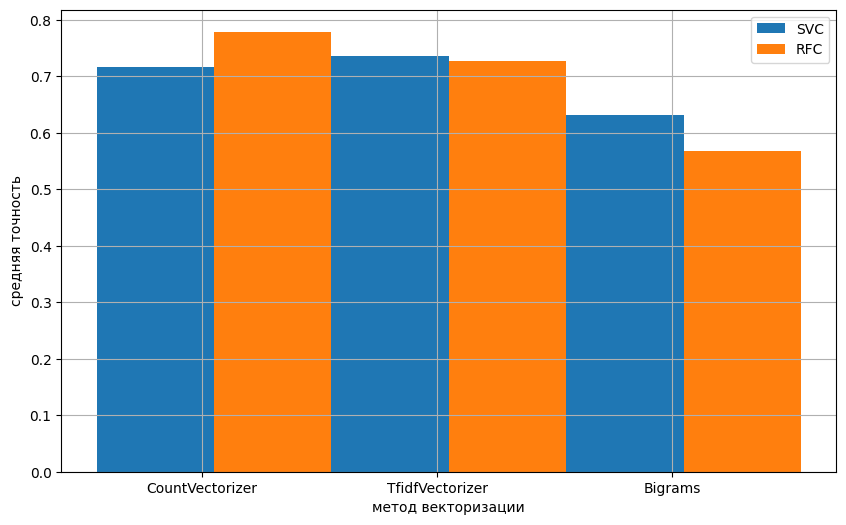

In [34]:
# рисуем графики

methods = ['CountVectorizer', 'TfidfVectorizer', 'Bigrams']

plt.figure(figsize=(10, 6))
x = np.arange(len(methods))

statistics = {
    'SVC': {'CountVectorizer': statistics[0][1], 'TfidfVectorizer': statistics[1][1], 'Bigrams': statistics[2][1]},
    'RFC': {'CountVectorizer': statistics[3][1], 'TfidfVectorizer': statistics[4][1], 'Bigrams': statistics[5][1]}
}

for i, model in enumerate(['SVC', 'RFC']):
    plt.bar(x + i * 0.5, statistics[model].values(), width=0.5, label=model)
    

plt.xlabel('метод векторизации')
plt.ylabel('средняя точность')
plt.xticks(x + 0.4 / 2, methods)
plt.grid(True)
plt.legend()